# Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm as progress 
from tensorflow.keras import Model
from tensorflow.data import Dataset 
from tensorflow.nn import relu, max_pool1d
from tensorflow.keras.optimizers import Adam
from pandas import read_csv, DataFrame, concat
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, Bidirectional, GRU, Dense
from tensorflow import convert_to_tensor, squeeze, GradientTape, device, DeviceSpec, reshape, expand_dims
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Constant Variables
batch_size = 4096

# Loading SMS Data

In [2]:
df = read_csv("../../data/sms.csv")
df = df.drop(columns=["Unnamed: 0"])
df.sample(5)

,text,type
1166,"[704, 760, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
829,"[184, 428, 760, 17, 192, 17, 361, 1596, 2257, ...",0
3943,"[3, 3, 3, 251, 17, 17, 17, 776, 15, 36, 3, 282...",0
5427,"[5832, 133, 4, 632, 765, 531, 96, 133, 5832, 9...",1
1152,"[53, 36, 615, 854, 17, 17, 17, 0, 0, 0, 0, 0, ...",0


# Preparing SMS Data


In [3]:
# Load & Prepare Data
df["text"] = df["text"].apply(lambda sms: [int(word) for word in sms[1:-1].split(", ")])
df["type"] = df["type"].apply(lambda label: int(label))

# # Train / Valid / Test Split
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["type"], test_size=0.30, stratify=df["type"], random_state=2022)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.50, stratify=y_test, random_state=2022)

# Train / Test / Valid Dataset
train_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_train.to_list()), convert_to_tensor(y_train.to_list()))).batch(batch_size=batch_size)
valid_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_valid.to_list()), convert_to_tensor(y_valid.to_list()))).batch(batch_size=batch_size)
test_dataset = Dataset.from_tensor_slices((convert_to_tensor(x_test.to_list()), convert_to_tensor(y_test.to_list()))).batch(batch_size=batch_size)


# Model

In [41]:
class SMSClassifier(Model):
    def __init__(self, path):
        super(SMSClassifier, self).__init__()
        self.path = path
        self.embedding = Embedding(6260, 8)
        self.dropout1 = Dropout(0.5)
        self.conv1 = Conv1D(8, kernel_size=3, strides=1)
        self.dropout2 = Dropout(0.5)
        self.conv2 = Conv1D(16, kernel_size=4, strides=1)
        self.dropout3 = Dropout(0.5)
        self.conv3 = Conv1D(24, kernel_size=5, strides=1)
        self.dropout4 = Dropout(0.5)
        self.gru1 = Bidirectional(GRU(24))
        self.dropout5 = Dropout(0.5)
        self.gru2 = Bidirectional(GRU(48))
        self.dropout6 = Dropout(0.5)
        self.gru3 = Bidirectional(GRU(96, activation="tanh"))
        self.dropout7 = Dropout(0.5)
        self.fc1 = Dense(200, activation="relu")
        self.fc2 = Dense(100, activation="relu")
        self.fc3 = Dense(1, activation="sigmoid")

    def call(self, sentence):
        sentence = self.embedding(sentence)
        sentence = self.dropout1(sentence)
        sentence = self.conv1(sentence)
        sentence = relu(sentence)
        sentence = max_pool1d(sentence, ksize=3, strides=1, padding="SAME")
        sentence = self.dropout2(sentence)
        sentence = self.conv2(sentence)
        sentence = relu(sentence)
        sentence = max_pool1d(sentence, ksize=4, strides=1, padding="SAME")
        sentence = self.dropout3(sentence)
        sentence = self.conv3(sentence)
        sentence = relu(sentence)
        sentence = max_pool1d(sentence, ksize=5, strides=1, padding="SAME")
        sentence = reshape(sentence, (sentence.shape[0], sentence.shape[2], sentence.shape[1]))
        sentence = self.dropout4(sentence)
        sentence = self.gru1(sentence)
        sentence = relu(sentence)
        sentence = expand_dims(sentence, -1)
        sentence = max_pool1d(sentence, ksize=6, strides=1, padding="SAME")
        sentence = self.dropout5(sentence)
        sentence = self.gru2(sentence)
        sentence = relu(sentence)
        sentence = expand_dims(sentence, -1)
        sentence = max_pool1d(sentence, ksize=7, strides=1, padding="SAME")
        sentence = self.dropout6(sentence)
        sentence = self.gru3(sentence)
        sentence = relu(sentence)
        sentence = expand_dims(sentence, -1)
        sentence = max_pool1d(sentence, ksize=8, strides=1, padding="SAME")
        sentence = squeeze(sentence)
        sentence = self.dropout7(sentence)
        sentence = self.fc1(sentence)
        sentence = self.fc2(sentence)
        sentence = self.fc3(sentence)
        return sentence

    def fit(self, datasets, epochs, optimizer, loss_fn, train_loss=[1], valid_loss=[1], best_epoch=0):
        with device(DeviceSpec(device_type="GPU")):
            for epoch in (tracker := progress(range(epochs))):
                tracker.set_description(f"Epoch #{epoch+1}")
                # Train Step
                self.train_step(datasets[0], optimizer, loss_fn)
                train_loss.append(self.train_step(datasets[0], optimizer, loss_fn))
                # Eval Step
                valid_loss.append(self.eval_step(datasets[1], loss_fn))
                # Saving Model If Performance Improves
                if valid_loss[-1] <= min(valid_loss):
                    best_epoch = epoch
                    self.save(self.path)
                # Updating the tracker
                if epoch == epochs-1:
                    tracker.set_description(f"Best Epoch #{best_epoch+1}")
                    tracker.set_postfix_str(f"Training Loss = {train_loss[best_epoch]}, Validiation Loss = {valid_loss[best_epoch]}")
                else:
                    tracker.set_postfix_str(f"Training Loss = {train_loss[-1]}, Validiation Loss = {valid_loss[-1]}")
                    
        # Plotting Results
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4), dpi=250)
        ax.set_title("Training Loss (Green) vs Validation Loss (Blue)")
        ax.plot(train_loss, "g")
        ax.plot(valid_loss, "b")
        ax.set_xlim((0, len(train_loss)-1))
        ax.set_ylim((0, max(max(train_loss), max(valid_loss))))
        plt.show()
        
    def train_step(self, dataset, optimizer, loss_fn):
        for step, batch in enumerate(dataset):
            with GradientTape() as tape:
                y_pred = self(batch[0], training=True)
                loss = loss_fn(batch[1], y_pred)
            grads = tape.gradient(loss, self.trainable_weights)
            optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return loss.numpy()
    
    def eval_step(self, dataset, loss_fn):
        for step, batch in enumerate(dataset):
            y_pred = self(batch[0], training=False)
            loss = loss_fn(batch[1], y_pred)
        return loss.numpy()
    
    def evaluate(self, dataset, y_pred=[], y_true=[]):
        self.load(self.path)
        for step, batch in enumerate(dataset):
            y_pred.extend([int(prediction[0] > 1e-3) for prediction in (self(batch[0], training=False).numpy())])
            y_true.extend(batch[1])
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        rc1, rc2, rc3 = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(rc2,  rc1)
        print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nPR_AUC: {pr_auc}")
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=[0, 1]).plot()
        plt.show()
        return accuracy, precision, recall, pr_auc
    
    def saveResults(self, lib, nam, typ, acc, pre, rec, pr):
        df = read_csv("../../data/results.csv")
        df2 = DataFrame([[lib, nam, typ, acc, pre, rec, pr]], 
                        columns=["Library", "Model", "Type", "Accuracy", "Precision", "Recall", "PR_AUC"])
        df = concat([df2, df])
        if "Unnamed: 0" in df:
            df = df.drop(columns=["Unnamed: 0"])
        df.to_csv("../../data/results.csv")

    def save(self, path):
        self.save_weights(path)

    def load(self, path, input_shape=(batch_size, 300)):
        self.build(input_shape)
        self.load_weights(path)

    def print(self, input_shape=(batch_size, 300)):
        self.build(input_shape)
        self.summary()

# Model Summary

In [42]:
model = SMSClassifier(path="../../models/cnn_gru.h5")
model.print()

Model: "sms_classifier_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  50080     
_________________________________________________________________
dropout_70 (Dropout)         multiple                  0         
_________________________________________________________________
conv1d_30 (Conv1D)           multiple                  200       
_________________________________________________________________
dropout_71 (Dropout)         multiple                  0         
_________________________________________________________________
conv1d_31 (Conv1D)           multiple                  528       
_________________________________________________________________
dropout_72 (Dropout)         multiple                  0         
_________________________________________________________________
conv1d_32 (Conv1D)           multiple            

# Model Training

Best Epoch #38: 100%|██████████| 300/300 [03:33<00:00,  1.41it/s, Training Loss = 0.19105656445026398, Validiation Loss = 0.26638972759246826]  


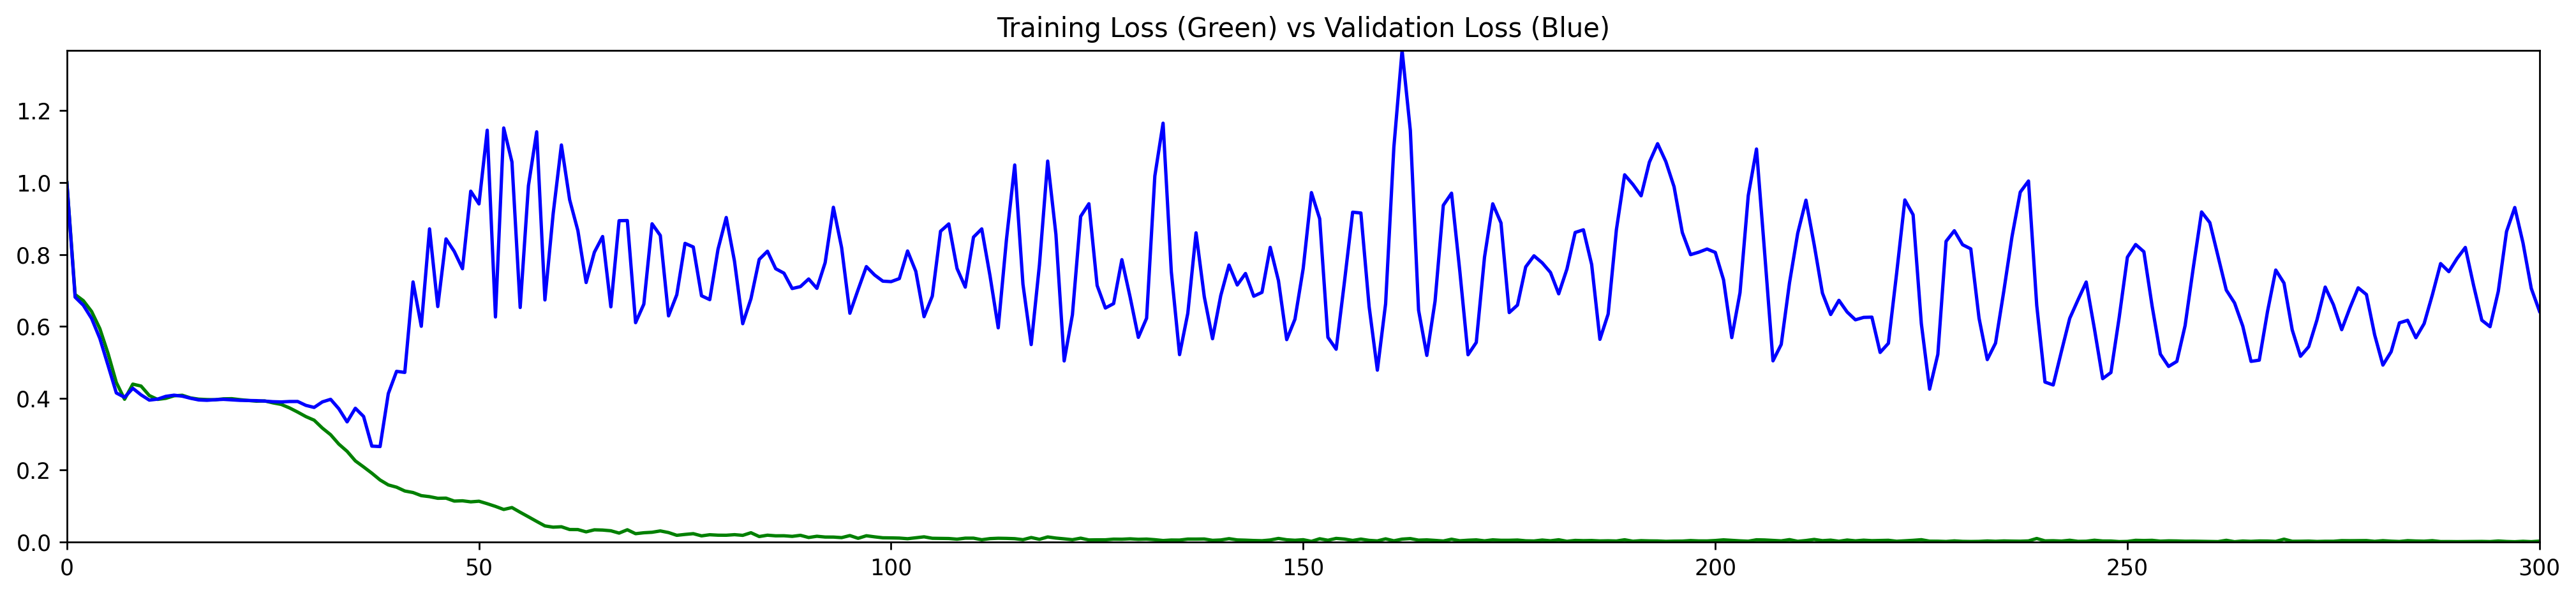

In [37]:
model.fit([train_dataset, valid_dataset], 300, Adam(learning_rate=1e-3), BinaryCrossentropy())

# Model Evaluation

Train Results
Accuracy: 0.1341025641025641
Precision: 0.1341025641025641
Recall: 1.0
PR_AUC: 0.5670512820512821


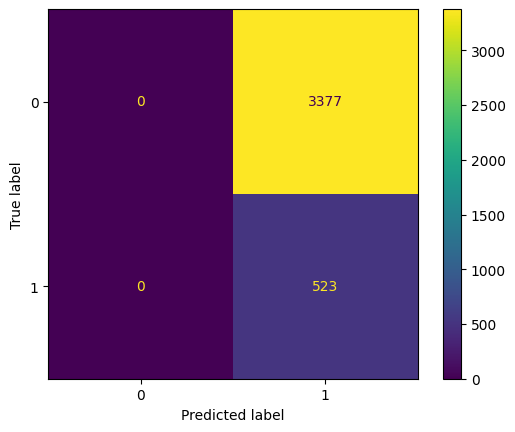

In [43]:
print("Train Results")
acc, pre, re, pr = model.evaluate(train_dataset)
model.saveResults("tensorflow", "cnn_gru", "train", acc, pre, re, pr)

Valid Results
Accuracy: 0.13407939189189189
Precision: 0.13407939189189189
Recall: 1.0
PR_AUC: 0.5670396959459459


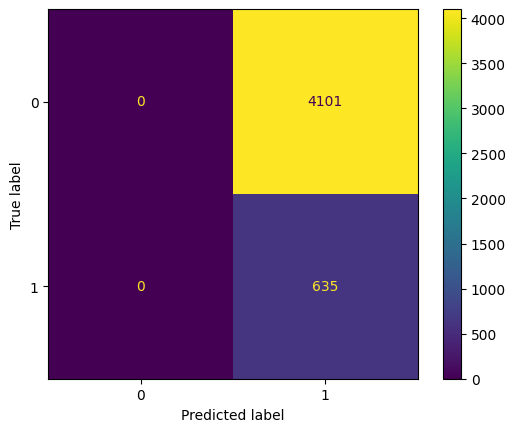

In [44]:
print("Valid Results")
acc, pre, re, pr = model.evaluate(valid_dataset)
model.saveResults("tensorflow", "cnn_gru", "valid", acc, pre, re, pr)

Test Results
Accuracy: 0.13406317300789664
Precision: 0.13406317300789664
Recall: 1.0
PR_AUC: 0.5670315865039484


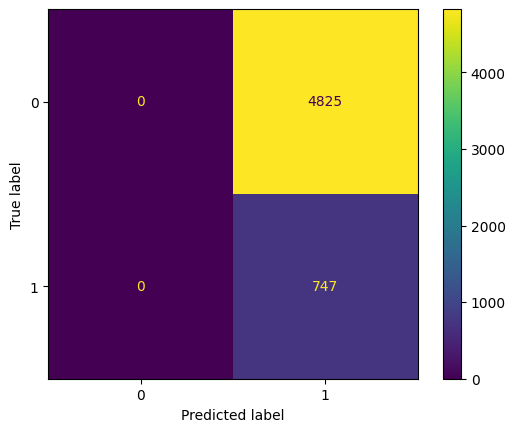

In [45]:
print("Test Results")
acc, pre, re, pr = model.evaluate(test_dataset)
model.saveResults("tensorflow", "cnn_gru", "test", acc, pre, re, pr)